# Random Walks en Multiplex de Aerolíneas

## Directorio

In [1]:
#Establecer directorio
cd("$(homedir())/Documents/UNAM/Tesis_Lic")

## Paquetes

Se importan todos los paquetes que se necesitarán para las funciones y visualizaciones del proyecto.

In [2]:
using StatsBase

#using NamedArrays
#using CSV
#using LightGraphs
#using DataFrames

In [3]:
using DelimitedFiles

In [4]:
using RandomNumbers.Xorshifts

In [5]:
using Plots

## Funciones

### Importar datos

In [6]:
"""
    importar_matriz(file::string)

Función que importa el archivo de la matriz de adyacencia de R.
"""
function importar_matriz(arch::AbstractString)
    archivo_R = readdlm(arch, ',') 
    archivo_R = archivo_R[2:end, :]
    matriz = archivo_R[:, 2:end]
    nombre = convert(Array{Int64,2}, matriz)
    return nombre
end

importar_matriz

### Nombres de datos

In [7]:
"""
    data_names(M)

Función que obtiene un arreglo con los nombres de aeropuertos de la matriz
"""
function data_names(arch::AbstractString)
    archivo_R = readdlm(arch, ',')
    columna = archivo_R[1, :]
    nombres = columna[2:end]
    return nombres
end

data_names

### Grado

In [8]:
"""

    n_in_degree(M::Array{Int64,2}, n::Int64)

Función que obtiene el grado de entrada de un cierto nodo n de la red representada por la matriz de adyacencia M.

Parámetros:
M matriz de adyacencia que acepta un arreglo de tipo Array{Int64,2}
n nodo a evaluar de tipo Int64

Resultado:
Grado de entrada del nodo n representado por un valor numérico de tipo Int64

Implementación

#### Ejemplos
"""
function n_in_degree(M::Array{Int64,2}, n::Int64)
    grado_entrada = sum(M[n, :])
end

n_in_degree

In [9]:
"""
in_degree(M)

Función que obtiene el grado de entrada de una red representada por la matriz de adyacencia M.

Parámetros:
* M matriz de adyacencia que acepta un arreglo de tipo Array{Int64,2}

Resultado:
Devuelve un arreglo de tipo Array{Int64,2} que contiene los grados de entrada de todos los nodos n de la red.

## Implementación

### Ejemplos
"""
function in_degree(M::Array)
    grados_entrada = sum(M, dims = 2)
end

in_degree

In [10]:
"""
    n_out_degree(M, n)

Función que obtiene el grado de salida de un cierto nodo n de la red representada por la matriz de adyacencia M.

Parámetros:
* M matriz de adyacencia que acepta un arreglo de tipo Array{Int64,2}
* n nodo a evaluar de tipo Int64

Resultado:
Grado de salida del nodo n representado por un valor numérico de tipo Int64

## Implementación

### Ejemplos
"""

function n_out_degree(M::Array{Int64,2}, n::Int64)
    grado_salida = sum(M[:, n])
end

n_out_degree (generic function with 1 method)

In [11]:
"""
    out_degree(M)

Función que obtiene el grado de salida de una red representada por la matriz de adyacencia M.

Parámetros:
* M matriz de adyacencia que acepta un arreglo de tipo Array{Int64,2}

Resultado:
Devuelve un arreglo de tipo Array{Int64,2} que contiene los grados de salida de todos los nodos n de la red.

## Implementación

### Ejemplos
"""
function out_degree(M::Array)
    grados_salida = sum(M, dims = 1)
end

out_degree

### Distribución de grado

In [12]:
"""
Función de distribución de grado de entrada
"""
function distrib_in_degree(M::Array)
    x = in_degree(M)
    degree_count = counts(x)
    return degree_count
end

distrib_in_degree

In [13]:
"""
Función de distribución de grado de salida
"""
function distrib_out_degree(M::Array)
    x = out_degree(M)
    degree_count = counts(x)
    return degree_count
end

distrib_out_degree

In [14]:
function plot_distrib(M::Array, tipo::String, titulo::String, color::String)
    
    pyplot()
    
    if tipo == "in"
        distribucion = distrib_in_degree(M::Array)
    elseif tipo == "out"
        distribucion = distrib_out_degree(M::Array)
    end
    distribucion
    #@show distribucion
    graph = bar(distribucion, fillcolor = color, markersize = 3, linealpha = 0.5, 
    title = titulo, 
    xlabel = "Grado", 
    ylabel = "Frecuencia",
    xlims = (-10,300), #obtener límites
    ylims = (-10,1000)) #obtener límites
end

plot_distrib (generic function with 1 method)

In [15]:
function plot_distrib(M::Array, tipo::String, titulo::String, color::String)
    
    pyplot()
    
    if tipo == "in"
        distribucion = distrib_in_degree(M::Array)
    elseif tipo == "out"
        distribucion = distrib_out_degree(M::Array)
    end
    distribucion
    #@show distribucion
    graph = bar(distribucion, fillcolor = color, markersize = 3, linealpha = 0.5, 
    title = titulo, 
    xlabel = "Grado", 
    ylabel = "Frecuencia",
    xlims = (-10,300), #obtener límites
    ylims = (-10,1000)) #obtener límites
end

plot_distrib (generic function with 1 method)

### Vecinos

In [16]:
"""
    vecinos(M::Array{Int64,2})

Función que obtiene un conjunto de arreglos con los vecinos de cada nodo.
"""
function vecinos(M::Array{Int64,2})
    
    nodos = size(M, 1) #aeropuertos
    vecindades = []
    
    for i in 1:nodos
        vecinos = findall(x -> x != 0, M[i, :])
        push!(vecindades, vecinos)
    end
    vecindades
end

vecinos

### Random walks

In [17]:
"""

    r_walks(M::Array{Int64,2}, f::Int64, steps::Int64, iter::Int64)

La función r_walks tiene como parámetros:
M, matriz de adyacencia de tipo Array{Int64,2}
f, nodo inicial de tipo Int64
steps, número de pasos de tipo Int64
iter, número de iteraciones de tipo Int64.
La función crea un caminante aleatorio sobre la matriz, el cual tiene igual probabilidad de avanzar 
hacia cualquiera de sus vecinos.
Regresa un arreglo que contiene todas las trayectorias que tomó el caminante aleatorio.
"""
function r_walks(M::Array{Int64,2}, f::Int64, steps::Int64, iter::Int64)
    
    paths = zeros(Int64, (iter, steps + 1))
    s = f
    seed = 1
    vecindades = vecinos(M)

    for i in 1:iter
        paths[i, 1] = f
        
        for p in 1:steps 
            vecindad = vecindades[s]
            
            if vecindad == []
                break
            else
                a = sample(Xoroshiro128Plus(seed), vecindad) 
                paths[i, p + 1] = a
                s = a
                seed += 1
            end
            
        end
        s = f
        
    end
    
    return paths 
end

r_walks

In [18]:
"""

    random_walk(M::Array{Int64,2}, steps::Int64, iter::Int64)


La función random_walk tiene como parámetros:
M, matriz de adyacencia de tipo Array{Int64,2}
steps, número de pasos de tipo Int64
iter, número de iteraciones de tipo Int64.
La función crea un caminante aleatorio sobre la matriz con igual probabilidad de avanzar 
hacia cualquiera de sus vecinos. Esta función recorre todos los nodos de la red como
nodos iniciales y sobre ellos itera para obtener el número de caminos que se le pidió.
Regresa un arreglo que contiene arreglos asociados a todas las trayectorias que tomó el 
caminante aleatorio para cada nodo inicial de la red.
"""
function random_walk(M::Array{Int64,2}, steps::Int64, iter::Int64) 
    random_walks = []
    nodos = size(M, 1)
    for f in 1:nodos #aeropuertos
        paths = r_walks(M, f, steps, iter)
        push!(random_walks, paths)
    end
    random_walks
end

random_walk

### Longitud de caminatas

In [93]:
"""
    walk_length(W)
La función walk_length tiene como parámetros:
RW, arreglo de arreglos de tipo Array{Any,1} que corresponde al arreglo de caminatas aleatorias.
La función regresa un arreglo de arreglos que contiene las longitudes de todas las trayectorias que tomó el 
caminante aleatorio para cada nodo inicial de la red.
"""
function walk_length(W)
    
    longitudes = Array[]
    
    v = length(W) #tamaño de la matriz, número de nodos
    s = size(W[1], 1) #Es el número de iteraciones
    longitud = zeros(Int64, s)
    
    for i in 1:v
        
        for j in 1:s
               
            longitud[j] = findlast(x -> x != 0, W[i][j, :])
            
        end
         push!(longitudes, longitud)
        
        longitud = zeros(Int64, s)
    end
    return longitudes
        
end

walk_length

In [20]:
"""
    walk_av_length(W)
La función walk_av_length tiene como parámetro W, que es un arreglo de arreglos (que se puede obtener de la 
función walk_length). 
Regresa un arreglo con entradas correspondientes al promedio de las longitudes de 
las caminatas aleatorias para cada nodo de inicio antes de caer en un nodo con grado de salida 0.
"""

function walk_av_length(W) #Llamar a función
    
    proms = []
    wlength = walk_length(W)
    
    for i in 1:length(wlength)
        av = mean(wlength[i])
        push!(proms, av)
    end
    proms
end

walk_av_length (generic function with 1 method)

In [21]:
"""
    walk_layer_length(W)
Función que saca el promedio de longitud de caminata en la capa
"""
function walk_layer_length(W)
    
    x = walk_av_length(W)
    av = mean(x)
    
    return av
end

walk_layer_length

### Nodos/aeropuertos visitados

In [22]:
"""
    nodos_visitados(W)
La función caminos tiene como parámetro W que es un arreglo de arreglos.
Regresa los nodos diferentes a los que llega el caminante.
"""
function nodos_visitados(W)
    
    cobert = []
    v = length(W) #tamaño de la matriz, número de nodos
    s = size(W[1], 1) #lo puedo sacar, para todos es el mismo. Es el número de iteraciones
    t = size(W[1], 2) #número de pasos, no necesario
    #visit = zeros(Int64, s) #Arreglo de ceros de tamaño número de iteraciones
    visit = []
    
    for i in 1:v        
        for j in 1:s
            u = unique(W[i][j, :])
            push!(visit, u)
        end
        
        push!(cobert, visit)
        visit = []
    end
    
    return cobert
end

nodos_visitados

### Frecuencia de visitas

In [23]:
"""
    freq_visitas_nodos(W::Array)

Función que hace un diccionario con frecuencias de visitas
"""
function freq_visitas_nodos(W::Array)
    
    dicc = [] #arreglo vacío
    
    nodos = length(W) #tamaño de caminatas
    iter = size(W[1], 1) #núm de iteraciones
    diccionario = 0
    
    #for i = n
    for i in 1:nodos #corro por todos los nodos
        for j in 1:iter #corro por las iteraciones
            diccionario = countmap(W[i][j, :]) #hago diccionario de freqs de cada caminata
            push!(dicc, diccionario) #guardo el diccionario en un arreglo vacío
        end
        
        diccionario = 0
    end
    return dicc
end

freq_visitas_nodos

In [107]:
rw[1]

5×11 Array{Int64,2}:
 1  2  1  2  1  2  1  2  3  0  0
 1  2  3  0  0  0  0  0  0  0  0
 1  2  3  0  0  0  0  0  0  0  0
 1  2  3  0  0  0  0  0  0  0  0
 1  2  1  2  1  2  1  2  1  2  3

In [105]:
freq_visitas_nodos(rw)

15-element Array{Any,1}:
 Dict(0=>2,2=>4,3=>1,1=>4)
 Dict(0=>8,2=>1,3=>1,1=>1)
 Dict(0=>8,2=>1,3=>1,1=>1)
 Dict(0=>8,2=>1,3=>1,1=>1)
 Dict(2=>5,3=>1,1=>5)     
 Dict(0=>9,2=>1,3=>1)     
 Dict(0=>3,2=>4,3=>1,1=>3)
 Dict(0=>1,2=>5,3=>1,1=>4)
 Dict(0=>3,2=>4,3=>1,1=>3)
 Dict(0=>1,2=>5,3=>1,1=>4)
 Dict(0=>10,3=>1)         
 Dict(0=>10,3=>1)         
 Dict(0=>10,3=>1)         
 Dict(0=>10,3=>1)         
 Dict(0=>10,3=>1)         

In [24]:
"""
    distrib_visitas_nodos(W)

Función que crea un arreglo de arreglos con la distribución de frecuencia de visitas
"""
function distrib_visitas_nodos(W)
    
    x = freq_visitas_nodos(W) #diccionario de frecuencias
    l = length(W)
    f = 0
    frec_total = [] #zeros(Array, length(x)) #arreglo de ceros de tamaño núm dicc
    frec_nodo = zeros(Int64, l+1) #arreglo de nodos de tamaño núm nodos para get frec

    for i in 1:length(x) #corro por los nodos

        for j in 1:l+1 #corro por los nodos

            frec_nodo[j] = get(x[i], f, 0) #entrada j de freq nodo la cambio por la entrada j del dicc i
            f += 1
        end
        push!(frec_total, frec_nodo)
        
        f = 0
        frec_nodo = zeros(Int64, l+1)
        
    end
    
    return frec_total
end

distrib_visitas_nodos

In [108]:
distrib_visitas_nodos(rw)

15-element Array{Any,1}:
 [2, 4, 4, 1] 
 [8, 1, 1, 1] 
 [8, 1, 1, 1] 
 [8, 1, 1, 1] 
 [0, 5, 5, 1] 
 [9, 0, 1, 1] 
 [3, 3, 4, 1] 
 [1, 4, 5, 1] 
 [3, 3, 4, 1] 
 [1, 4, 5, 1] 
 [10, 0, 0, 1]
 [10, 0, 0, 1]
 [10, 0, 0, 1]
 [10, 0, 0, 1]
 [10, 0, 0, 1]

In [25]:
"""
    plot_visit_freq(W)

Función que hace un heatmap de nodos en los que cae, cada renglón corresponde a una caminata
"""
function plot_visit_freq(W)
    
    pyplot()
    x = distrib_visitas_nodos(W)
    h = transpose(hcat(x...))

    xs = [string("n", i) for i = 0:1:length(W)]
    ys = [string("rw", i) for i = 1:length(x)]
    z = h
    heatmap(xs, ys, z, aspect_ratio=1)
end

plot_visit_freq

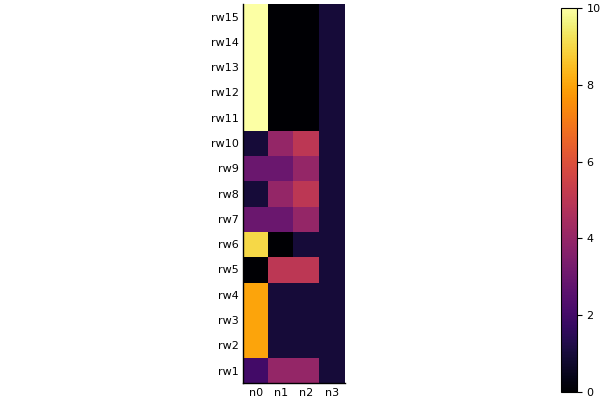

In [109]:
plot_visit_freq(rw)

In [26]:
"""
    freq_visitas_nodo(W::Array, n)

Función que hace un diccionario con frecuencias para un nodo inicial
"""
function freq_visitas_nodo(W::Array, n) #puede ser más eficiente llamando la función anterior sin nodo
    
    dicc = [] #arreglo vacío
    
    nodos = length(W) #tamaño de caminatas
    iter = size(W[1], 1) #núm de iteraciones
    diccionario = 0
    
    for j in 1:iter #corro por las iteraciones
          
        diccionario = countmap(W[n][j, :]) #hago diccionario de freqs de cada caminata
          
        push!(dicc, diccionario) #guardo el diccionario en un arreglo vacío
          
    end
    
    return dicc
end

freq_visitas_nodo

In [110]:
freq_visitas_nodo(rw,1)

5-element Array{Any,1}:
 Dict(0=>2,2=>4,3=>1,1=>4)
 Dict(0=>8,2=>1,3=>1,1=>1)
 Dict(0=>8,2=>1,3=>1,1=>1)
 Dict(0=>8,2=>1,3=>1,1=>1)
 Dict(2=>5,3=>1,1=>5)     

In [27]:
"""
    distrib_visitas_nodo(W, n)

Función que crea un arreglo de arreglos con la distribución de frecuencias de visitas de un nodo inicial
"""
function distrib_visitas_nodo(W, n)
    
    x = freq_visitas_nodo(W, n) #diccionario de frecuencias
    l = length(W)
    f = 0
    frec_total = [] #zeros(Array, length(x)) #arreglo de ceros de tamaño núm dicc
    frec_nodo = zeros(Int64, l+1) #arreglo de nodos de tamaño núm nodos para get frec

    for i in 1:length(x) #corro por los nodos

        for j in 1:l+1 #corro por los nodos

            frec_nodo[j] = get(x[i], f, 0) #entrada j de freq nodo la cambio por la entrada j del dicc i
            
            
            f += 1
        end
        push!(frec_total, frec_nodo)
        
        f = 0
        frec_nodo = zeros(Int64, l+1)
        
    end
    
    return frec_total
end

distrib_visitas_nodo

In [111]:
distrib_visitas_nodo(rw,1)

5-element Array{Any,1}:
 [2, 4, 4, 1]
 [8, 1, 1, 1]
 [8, 1, 1, 1]
 [8, 1, 1, 1]
 [0, 5, 5, 1]

In [113]:
"""
    plot_visit_freq_nodo(W, n)

Función que hace un heatmap de los nodos en los que cae, cada renglón corresponde a una caminata con cierto nodo inicial
"""
function plot_visit_freq_nodo(W, n)
    
    pyplot()
    x = distrib_visitas_nodo(W, n)
    h = transpose(hcat(x...))
    pasos = size(W[1],2)-1

    xs = [string("n", i) for i = 0:1:length(W)]
    ys = [string("rw", i) for i = 1:length(x)]
    z = h
    heatmap(xs, ys, z, aspect_ratio = 1, clims = (0, pasos))
end

plot_visit_freq_nodo

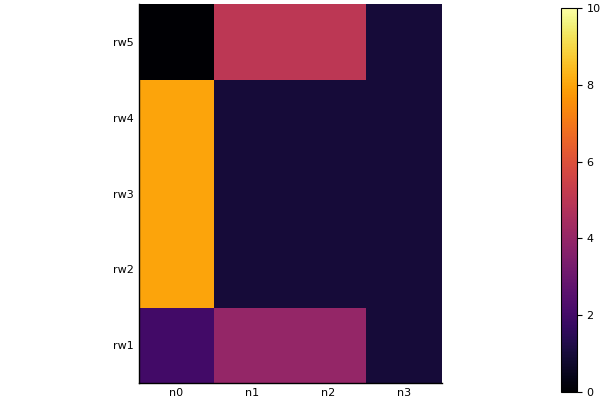

In [114]:
plot_visit_freq_nodo(rw,1)

In [129]:
"""
    distrib_nodos_prom(W::Array)

Función que hace una distribución por nodo inicial y muestra todos los nodos iniciales
"""
function distrib_nodos_prom(W::Array)
    
    nodos = length(W) #número de nodos
    dicc = zeros(Float64, nodos, nodos+1) #matriz de ceros (nodos x nodos+1)
    nombres = 1:1:nodos
    
    for i in 1:nodos #corro por todos los nodos nombres #
        conteos = counts(W[i]) #hago diccionario de freqs de cada caminata
        dicc[i, :] = conteos 
    end

    dicc
end

distrib_nodos_prom

In [127]:
distrib_nodos_prom(rw)

3×4 Array{Float64,2}:
 26.0  12.0  12.0  5.0
 17.0  14.0  19.0  5.0
 50.0   0.0   0.0  5.0

In [103]:
mat = [0 1 0
       1 0 1
       0 0 0]
rw = random_walk(mat, 10, 5)

3-element Array{Any,1}:
 [1 2 … 0 0; 1 2 … 0 0; … ; 1 2 … 0 0; 1 2 … 2 3]
 [2 3 … 0 0; 2 1 … 0 0; … ; 2 1 … 0 0; 2 1 … 3 0]
 [3 0 … 0 0; 3 0 … 0 0; … ; 3 0 … 0 0; 3 0 … 0 0]

In [30]:
"""
    plot_freq_nodos_prom(W::Array)

Función que crea un diccionario con frecuencias por nodo inicial y muestra todos
"""
function plot_freq_nodos_prom(W::Array)
    
    pyplot()
    x = distrib_nodos_prom(W)
    
    xs = [string("n", i) for i = 0:1:length(W)]
    ys = [string("rw", i) for i = 1:length(W)]
    z = x
    heatmap(xs, ys, z, aspect_ratio = 1, clims = (0, maximum(x)))
end

plot_freq_nodos_prom

### Cobertura

In [31]:
"""
La función cobertura tiene como parámetro W que es un arreglo de arreglos.
Regresa el número de nodos diferentes a los que llega el caminante.
"""
function cobertura(W) 
    
    cobert = []
    
    v = length(W) #tamaño de la matriz, número de nodos
    x = nodos_visitados(W)
    s = size(x[1], 1) #lo puedo sacar, para todos es el mismo. Es el número de iteraciones
    longz = zeros(Int64, s) #Arreglo de ceros de tamaño número de iteraciones
    
    for i in 1:v        
        for j in 1:s
            l = length(x[i][j])
            longz[j] = l
        end
        push!(cobert, longz)
        longz = zeros(Int64, s)
    end
    return cobert
end

cobertura

In [32]:
"""
    n_cobertura_av(W)
Da el promedio de cobertura la caminata por nodo inicial. 
"""
function n_cobertura_av(W) #Esta es la importante
    
    longitud = []
    x = cobertura(W)
    
    for i in 1:length(x)
        l = mean(x[i])
        push!(longitud, l)
    end
    longitud
end



n_cobertura_av

In [33]:
"""
    cobertura_av(W)

Da el promedio de la longitud de las caminatas para todos los nodos, como un número.
"""
function cobertura_av(W)
    x = n_cobertura_av(W)
    promedio = mean(x)
    return promedio
end

cobertura_av

### Máximos y mínimos de longitud

In [34]:
"""
    max_length(W)
Da la longitud máxima de cada iteración de cada nodo inicial.
"""
function max_length(W)
    max = []
    x = cobertura(W)
    for i in 1:length(x)
        m = maximum(x[i])
        push!(max, m)
    end
    max
end

max_length

In [35]:
"""
    Max_length(W)
Da la longitud máxima total.
"""
function Max_length(W)
    x = max_length(W)
    m = maximum(x)
    return m
end

Max_length

In [36]:
"""
    av_max_length(W)
Regresa el promedio de la longitud máxima de cada nodo inicial.
"""
function av_max_length(W)
    x = max_length(W)
    prom = mean(x)
    return prom
end

av_max_length

In [37]:
"""
    min_length(W)
Da la longitud mínima de cada iteración de cada nodo inicial.
"""
function min_length(W)
    min = []
    x = cobertura(W)
    for i in 1:length(x)
        m = minimum(x[i])
        push!(min, m)
    end
    min
end

min_length

In [38]:
"""
    Min_length(W)
Da la longitud mínima total.
"""
function Min_length(W)
    x = min_length(W)
    m = minimum(x)
    return m
end

Min_length

In [39]:
"""
    av_min_length(W)
Regresa el promedio de la longitud mínima de cada nodo inicial.
"""
function av_min_length(W)
    x = min_length(W)
    prom = mean(x)
    return prom
end

av_min_length

### Endpoints

In [40]:
"""
    endpoints(W)

Regresa un arreglo de arreglos que contiene los nodos en los que cae cada caminata y ya no puede salir.
"""
function endpoints(W) 
    x = nodos_visitados(W)
    atractores = [] #Arreglo vacío que contenga a los atractores
    v = length(W) #tamaño de la matriz, número de nodos
    s = size(W[1], 1) #lo puedo sacar, para todos es el mismo. Es el número de iteraciones
    t = size(W[1], 2) #número de pasos +1
    atract = zeros(Int64, s) #Arreglo de ceros de tamaño número de iteraciones
    
    for i in 1:v        
        for j in 1:s
            if x[i][j, :][end][end] == 0
                at = x[i][j, :][end][end - 1]
                atract[j] = at
            else
                atract[j] = 0
            end
        end
        push!(atractores, atract)
        atract = zeros(Int64, s)
    end
    return atractores
end

endpoints

In [41]:
"""
    av_n_endpoints(W)
Función que calcula el promedio de endpoints por nodo
"""
function av_n_endpoints(W) 
    
    x = endpoints(W)
    atractores_prom = [] #Arreglo vacío que contenga a los atractores
    v = length(W) #tamaño de la matriz, número de nodos

    for i in 1:v        
        av = mean(x[i])
        push!(atractores_prom, av)
    end
    atractores_prom
end

av_n_endpoints

### Distribución de frecuencia de endpoints

In [42]:
"""
    freq_endpoints(W)
Función que da un diccionario con frecuencias
"""
function freq_endpoints(W)
    freqs = []
    x = endpoints(W)
    v = length(W)
    
    for i in 1:v
        frec = countmap(x[i])
        push!(freqs, frec)
    end
    freqs
end

freq_endpoints

In [43]:
"""
    distrib_endpoints(W)
Función que saca la distribución de los atractores para toda la capa
"""
function distrib_endpoints(W)
    x = freq_endpoints(W)
    frec_total = zeros(Int64, length(W))
    frec_nodo = zeros(Int64, length(W))

    for i in 1:length(W)
        for j in 1:length(W)
            frec_nodo[j] = get(x[i], j, 0)
        end
        frec_total += frec_nodo
    end
    
    return frec_total
end

distrib_endpoints

## Datos


### Multiplex Global

In [44]:
multiplex = importar_matriz("data/multi_17_du.csv")

3189×3189 Array{Int64,2}:
 0  0  0  1  0  0  0  1  1  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  1  0  0  0  1  1  1  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  1  0  0  0  1  1  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 1  1  1  0  1  1  1  1  1  1  1  1  1     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  1  0  0  1  1  1  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  1  0  0  0  0  1  1  1  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  1  1  0  0  0  1  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 1  1  1  1  1  0  0  0  1  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 1  1  1  1  1  1  1  1  0  1  1  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  1  0  1  0  1  0  0  1  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  1  0  1  0  0  1  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  1  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  1  0  0  0  0  0  0  0  0  0

In [45]:
nombres_multiplex = data_names("data/multi_17_du.csv")

3189-element Array{Any,1}:
 "AER"
 "ASF"
 "CEK"
 "DME"
 "EGO"
 "GYD"
 "KGD"
 "KZN"
 "LED"
 "MRV"
 "NBC"
 "NJC"
 "NUX"
 ⋮    
 "LPS"
 "ORX"
 "BVS"
 "MTE"
 "DLZ"
 "UII"
 "ZBF"
 "CMP"
 "BSS"
 "AEX"
 "GCK"
 "MGM"

## Distribuciones de grado

### Multiplex Global

#### Grado de entrada

In [46]:
in_degree_multiplex = in_degree(multiplex)

3189×1 Array{Int64,2}:
  17
   7
  14
 187
   9
  39
  10
  21
 110
  16
   7
   9
  10
   ⋮
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0
   0

In [47]:
distrib_in_multiplex = distrib_in_degree(multiplex)

238-element Array{Int64,1}:
  23
 894
 588
 324
 227
 138
  92
  87
  74
  62
  37
  29
  40
   ⋮
   0
   1
   0
   0
   0
   0
   0
   0
   0
   0
   0
   1

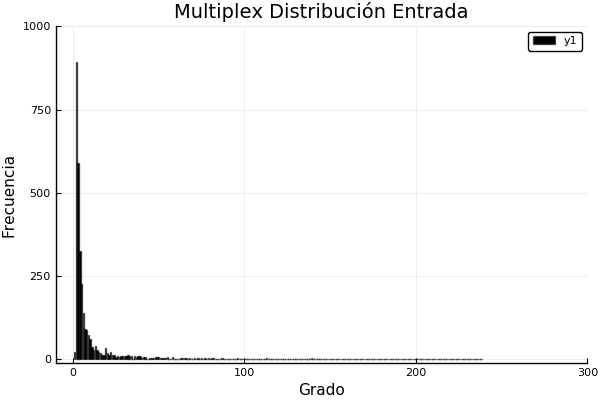

In [48]:
in_M = plot_distrib(multiplex, "in", "Multiplex Distribución Entrada", "black")

#### Grado de salida

In [49]:
out_degree_multiplex = out_degree(multiplex)

1×3189 Array{Int64,2}:
 18  7  14  186  9  39  10  21  112  …  1  3  1  1  1  1  1  1  1  1  1  1

In [50]:
distrib_out_multiplex = distrib_out_degree(multiplex)

234-element Array{Int64,1}:
  10
 908
 579
 333
 216
 141
  99
  85
  71
  68
  36
  33
  37
   ⋮
   0
   0
   0
   1
   0
   0
   0
   0
   1
   0
   0
   1

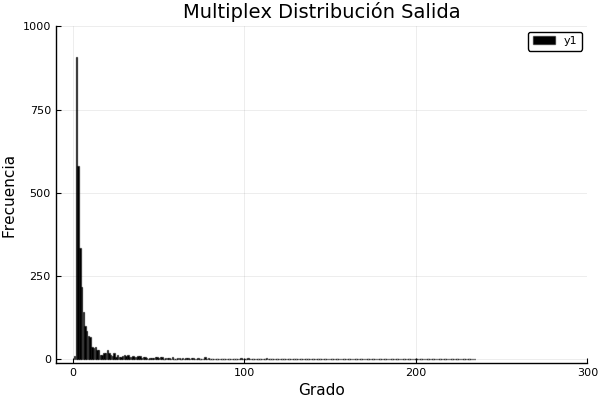

In [51]:
out_M = plot_distrib(multiplex, "out", "Multiplex Distribución Salida", "black")

## Vecinos

### Multiplex global

In [52]:
vecinos_M = @time vecinos(multiplex)

  0.268042 seconds (233.35 k allocations: 89.285 MiB, 9.03% gc time)


3189-element Array{Any,1}:
 [4, 8, 9, 15, 352, 594, 670, 671, 682, 724, 727, 728, 837, 998, 1527, 1531, 2274]                        
 [4, 8, 9, 10, 232, 594, 1829]                                                                            
 [4, 8, 9, 14, 90, 244, 478, 594, 682, 724, 725, 728, 1527, 1752]                                         
 [1, 2, 3, 5, 6, 7, 8, 9, 10, 11  …  2741, 2742, 2743, 2744, 2797, 2845, 2846, 2847, 2865, 3089]          
 [4, 7, 8, 9, 671, 725, 753, 759, 2408]                                                                   
 [4, 9, 10, 11, 14, 15, 232, 304, 319, 340  …  1015, 1527, 1530, 1531, 1532, 1561, 1829, 1960, 2274, 2282]
 [4, 5, 9, 193, 594, 684, 997, 1527, 1531, 1756]                                                          
 [1, 2, 3, 4, 5, 9, 15, 90, 242, 246  …  423, 594, 723, 724, 725, 727, 728, 730, 1527, 1752]              
 [1, 2, 3, 4, 5, 6, 7, 8, 10, 11  …  2231, 2274, 2282, 2550, 2552, 2734, 2738, 2742, 2846, 2865]          
 [2, 4, 6,

## Caminatas aleatorias

### Multiplex

In [53]:
caminata_M = @time random_walk(multiplex, 2500, 100) #nuevo

924.434701 seconds (1.41 G allocations: 304.569 GiB, 9.55% gc time)


3189-element Array{Any,1}:
 [1 15 … 0 0; 1 1527 … 0 0; … ; 1 1531 … 1150 371; 1 594 … 1023 1877] 
 [2 594 … 0 0; 2 9 … 0 0; … ; 2 8 … 1201 404; 2 232 … 0 0]            
 [3 244 … 0 0; 3 594 … 0 0; … ; 3 1527 … 1202 1149; 3 594 … 1153 1128]
 [4 1226 … 0 0; 4 670 … 0 0; … ; 4 2740 … 457 486; 4 3 … 0 0]         
 [5 2408 … 0 0; 5 725 … 0 0; … ; 5 2408 … 2660 2657; 5 7 … 0 0]       
 [6 2282 … 0 0; 6 441 … 0 0; … ; 6 11 … 0 0; 6 494 … 457 486]         
 [7 5 … 0 0; 7 9 … 0 0; … ; 7 1531 … 0 0; 7 594 … 0 0]                
 [8 9 … 0 0; 8 728 … 0 0; … ; 8 594 … 0 0; 8 5 … 1391 1371]           
 [9 2 … 0 0; 9 188 … 0 0; … ; 9 2738 … 43 1656; 9 1823 … 0 0]         
 [10 4 … 0 0; 10 594 … 0 0; … ; 10 90 … 0 0; 10 683 … 223 418]        
 [11 724 … 0 0; 11 15 … 0 0; … ; 11 6 … 1150 371; 11 6 … 1023 1877]   
 [12 2797 … 0 0; 12 17 … 0 0; … ; 12 17 … 0 0; 12 15 … 457 486]       
 [13 14 … 0 0; 13 15 … 0 0; … ; 13 2275 … 0 0; 13 4 … 2000 449]       
 ⋮                                                

## Longitud de todas las iteraciones de caminatas 

In [94]:
li_M = @time walk_length(caminata_M)

 16.242225 seconds (1.95 M allocations: 6.004 GiB, 15.74% gc time)


3189-element Array{Array,1}:
 [1986, 1643, 216, 393, 685, 487, 487, 1234, 1361, 154  …  738, 57, 2501, 2501, 1742, 1623, 2501, 1863, 2501, 2501]  
 [246, 434, 106, 739, 465, 1643, 216, 1077, 487, 487  …  1029, 2501, 1422, 2501, 2501, 2501, 2501, 1657, 2501, 1825] 
 [165, 82, 434, 106, 739, 229, 1879, 359, 934, 487  …  882, 1048, 879, 2501, 1844, 2055, 704, 329, 2501, 2501]       
 [1986, 1643, 216, 393, 685, 487, 158, 330, 1234, 1361  …  576, 2501, 183, 2501, 847, 2501, 92, 1331, 2501, 738]     
 [1986, 1643, 1292, 487, 487, 1234, 1361, 2501, 2501, 1344  …  2501, 28, 799, 1021, 2501, 1422, 2501, 84, 2501, 691] 
 [1986, 1643, 216, 1077, 487, 487, 1234, 1361, 2501, 2501  …  139, 75, 606, 2501, 75, 2501, 955, 2501, 1422, 2501]   
 [1986, 1643, 55, 162, 393, 685, 487, 487, 1234, 1361  …  1604, 2501, 1422, 2501, 738, 2501, 2501, 1798, 224, 731]   
 [1986, 1643, 216, 1077, 487, 487, 1234, 1361, 2501, 2501  …  2501, 389, 2501, 139, 680, 2501, 183, 2501, 847, 2501] 
 [246, 1741, 1643, 359, 934

## Longitud promedio de las iteraciones de caminatas de cada nodo inicial

In [96]:
lpn_M = @time walk_av_length(caminata_M)

 16.347859 seconds (1.84 M allocations: 5.999 GiB, 16.57% gc time)


3189-element Array{Any,1}:
 1488.35
 1437.97
 1195.51
 1310.54
 1335.9 
 1303.17
 1388.04
 1263.96
 1335.9 
 1329.0 
 1488.35
 1303.17
 1335.54
    ⋮   
    1.0 
    1.0 
    1.0 
    1.0 
    1.0 
    1.0 
    1.0 
    1.0 
    1.0 
    1.0 
    1.0 
    1.0 

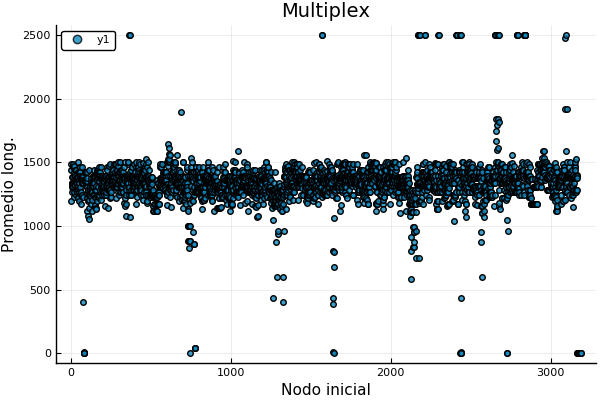

In [97]:
pyplot()
d_lpn_M = scatter(lpn_M, color="#0f87bf",alpha=0.8, 
    title="Multiplex", 
    xlabel="Nodo inicial", 
    ylabel="Promedio long.")

## Longitud promedio de caminatas por capa

In [95]:
wl_M = @time walk_layer_length(caminata_M)

 16.225222 seconds (1.86 M allocations: 6.000 GiB, 16.84% gc time)


1330.1215992474151

## Nodos visitados específicamente

In [58]:
#No lo corro ahora para que no se tarde tanto
#nv_M = @time nodos_visitados(caminata_M)

In [59]:
#Falta función de aeropuertos específicos

## Frecuencia de visitas

In [60]:
freq_visit_M = @time freq_visitas_nodos(caminata_M)

298.267421 seconds (12.17 M allocations: 62.746 GiB, 49.02% gc time)


318900-element Array{Any,1}:
 Dict(306=>1,1090=>2,1333=>1,1671=>3,1662=>1,176=>6,892=>3,285=>1,1481=>1,318=>3…)
 Dict(74=>1,3064=>5,176=>6,1481=>1,318=>2,3108=>1,2061=>1,354=>5,671=>2,1144=>1…) 
 Dict(461=>1,124=>1,643=>1,2=>1,638=>1,1097=>1,1135=>1,370=>1,1324=>1,1872=>1…)   
 Dict(633=>2,1993=>1,158=>4,1862=>1,1557=>1,478=>2,1895=>1,384=>1,57=>2,31=>2…)   
 Dict(633=>2,306=>1,1807=>1,1993=>2,491=>1,134=>1,158=>3,215=>2,2383=>1,2854=>1…) 
 Dict(633=>2,1760=>1,1090=>1,491=>1,478=>1,300=>2,1000=>1,1103=>1,289=>1,74=>2…)  
 Dict(633=>1,1760=>1,2677=>2,1564=>1,215=>1,582=>1,1557=>1,1869=>1,300=>2,173=>4…)
 Dict(1760=>1,74=>1,1662=>1,905=>1,176=>3,318=>3,1337=>1,2284=>1,354=>1,671=>2…)  
 Dict(1316=>1,2564=>5,2376=>1,74=>1,1265=>1,892=>3,1481=>2,318=>2,2061=>1,354=>1…)
 Dict(1564=>1,1763=>1,2854=>1,464=>1,193=>1,58=>3,478=>1,428=>1,1049=>1,2896=>1…) 
 Dict(1671=>1,1131=>2,74=>2,1662=>2,176=>3,1481=>3,318=>5,354=>1,1845=>1,563=>1…) 
 Dict(1760=>2,1090=>1,74=>1,176=>2,1469=>1,892=>1,285=>2,1

In [61]:
#distrib_visit_M = @time distrib_visitas_nodos(caminata_M)

In [62]:
#plot_visit_freq(caminata_M)

In [63]:
#freq_visitas_nodo(W::Array, n)

In [64]:
#distrib_visitas_nodos(caminata_M, n)

In [65]:
#plot_visit_freq_nodo(caminata_M, n)

In [130]:
distrib_prom_M = @time distrib_nodos_prom(caminata_M)

DimensionMismatch: DimensionMismatch("tried to assign 3168-element array to 1×3190 destination")

In [67]:
plot_freq_nodos_prom(caminata_M)

DimensionMismatch: DimensionMismatch("tried to assign 3168-element array to 1×3190 destination")

## Cobertura (nodos distintos)

In [68]:
cobi_M = @time cobertura(caminata_M)

455.853552 seconds (9.18 M allocations: 18.105 GiB, 67.64% gc time)


3189-element Array{Any,1}:
 [795, 712, 169, 262, 393, 310, 299, 611, 660, 123  …  420, 54, 878, 902, 715, 703, 893, 741, 874, 907] 
 [191, 276, 87, 415, 313, 717, 158, 550, 309, 310  …  508, 864, 680, 877, 99, 902, 877, 709, 891, 755]  
 [117, 68, 277, 87, 412, 180, 764, 235, 500, 308  …  452, 553, 466, 876, 732, 753, 406, 227, 914, 901]  
 [788, 723, 162, 260, 402, 311, 132, 222, 586, 660  …  346, 908, 149, 862, 438, 861, 72, 655, 876, 422] 
 [792, 712, 575, 308, 304, 601, 668, 840, 892, 599  …  923, 26, 421, 532, 864, 680, 904, 74, 35, 402]   
 [793, 712, 161, 548, 325, 298, 603, 657, 848, 883  …  106, 67, 362, 907, 63, 882, 478, 855, 647, 881]  
 [796, 713, 35, 131, 262, 404, 325, 303, 603, 658  …  673, 852, 690, 894, 422, 885, 899, 705, 159, 434] 
 [795, 720, 160, 544, 309, 283, 608, 659, 842, 878  …  866, 253, 945, 111, 393, 922, 151, 871, 450, 858]
 [187, 748, 729, 234, 479, 310, 316, 594, 656, 32  …  901, 895, 905, 672, 864, 672, 886, 76, 880, 403]  
 [787, 717, 161, 544, 299, 2

## Cobertura promedio de las caminatas de cada aeropuerto inicial

In [69]:
cobs_M = @time n_cobertura_av(caminata_M)

154.949943 seconds (9.14 M allocations: 18.104 GiB, 46.05% gc time)


3189-element Array{Any,1}:
 598.98
 559.26
 501.15
 537.81
 536.31
 538.84
 563.75
 520.1 
 541.55
 546.04
 579.76
 543.56
 544.85
   ⋮   
   2.0 
   2.0 
   2.0 
   2.0 
   2.0 
   2.0 
   2.0 
   2.0 
   2.0 
   2.0 
   2.0 
   2.0 

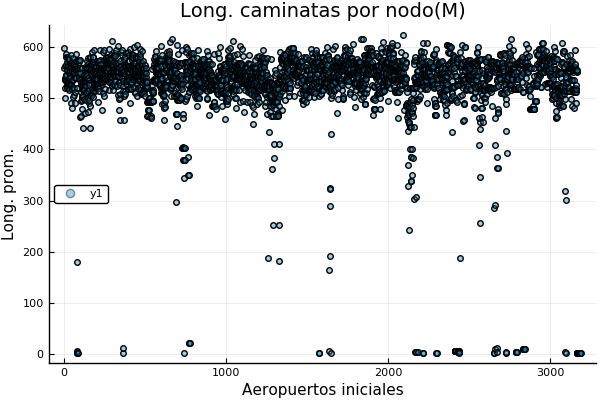

In [70]:
d_cobs_M = scatter(cobs_M, color="#0f87bf",alpha=0.4, 
    title="Long. caminatas por nodo(M)", 
    xlabel="Aeropuertos iniciales", 
    ylabel="Long. prom.")

## Cobertura promedio

In [71]:
cobp_M = @time cobertura_av(caminata_M)

119.843426 seconds (9.13 M allocations: 18.103 GiB, 37.09% gc time)


524.4462025713391

## Longitudes máximas de caminatas

In [72]:
lmax_M = @time max_length(caminata_M)

138.752128 seconds (9.17 M allocations: 18.105 GiB, 34.22% gc time)


3189-element Array{Any,1}:
 907
 902
 914
 908
 948
 945
 919
 945
 905
 922
 904
 912
 907
   ⋮
   2
   2
   2
   2
   2
   2
   2
   2
   2
   2
   2
   2

In [73]:
lMax_M = @time Max_length(caminata_M)

114.593507 seconds (9.16 M allocations: 18.105 GiB, 33.73% gc time)


954

In [74]:
lavmax_M = @time av_max_length(caminata_M)

192.329432 seconds (9.13 M allocations: 18.103 GiB, 50.20% gc time)


896.2119786767012

## Longitudes mínimas de caminatas

In [75]:
lmin_M = @time min_length(caminata_M)

130.356651 seconds (9.13 M allocations: 18.103 GiB, 35.60% gc time)


3189-element Array{Any,1}:
 28
 30
 50
 58
 26
 21
 18
 26
 32
 27
 24
 24
 14
  ⋮
  2
  2
  2
  2
  2
  2
  2
  2
  2
  2
  2
  2

In [76]:
lMin_M = @time Min_length(caminata_M)

144.405829 seconds (9.15 M allocations: 18.104 GiB, 36.08% gc time)


2

In [77]:
lavmin_M = @time av_min_length(caminata_M)

120.042650 seconds (9.12 M allocations: 18.103 GiB, 34.82% gc time)


17.851364063969896

## Endpoints

In [78]:
endpts_M = @time endpoints(caminata_M)

127.067321 seconds (10.84 M allocations: 18.173 GiB, 31.34% gc time)


3189-element Array{Any,1}:
 [3189, 3182, 3173, 3173, 3184, 3173, 3173, 3173, 3169, 3175  …  3173, 3172, 0, 0, 3174, 3188, 0, 3187, 0, 0]               
 [3179, 3182, 3184, 3182, 3189, 3182, 3173, 3184, 3173, 3173  …  3173, 0, 3187, 0, 0, 0, 0, 3188, 0, 3182]                  
 [3173, 3179, 3182, 3184, 3182, 3175, 3182, 3171, 3184, 3173  …  3187, 3175, 3188, 0, 3173, 3177, 3182, 3173, 0, 0]         
 [3189, 3182, 3173, 3173, 3184, 3173, 3179, 3173, 3173, 3169  …  3173, 0, 3173, 0, 3173, 0, 3173, 3187, 0, 3173]            
 [3189, 3182, 3184, 3173, 3173, 3173, 3169, 0, 0, 3184  …  0, 3173, 3183, 3173, 0, 3187, 0, 3189, 0, 3173]                  
 [3189, 3182, 3173, 3184, 3173, 3173, 3173, 3169, 0, 0  …  3177, 3186, 3173, 0, 3175, 0, 3173, 0, 3187, 0]                  
 [3189, 3182, 3171, 3173, 3173, 3184, 3173, 3173, 3173, 3169  …  3173, 0, 3187, 0, 3173, 0, 0, 3174, 3189, 3176]            
 [3189, 3182, 3173, 3184, 3173, 3173, 3173, 3169, 0, 0  …  0, 3173, 0, 3177, 3173, 0, 3173, 0, 317

In [79]:
av_endpts_M = @time av_n_endpoints(caminata_M)

150.081311 seconds (10.77 M allocations: 18.169 GiB, 38.83% gc time)


3189-element Array{Any,1}:
 2257.33
 2257.06
 2512.22
 2448.13
 2448.19
 2415.92
 2352.49
 2479.15
 2416.44
 2416.84
 2320.86
 2479.92
 2416.18
    ⋮   
 3178.0 
 3179.0 
 3180.0 
 3181.0 
 3182.0 
 3183.0 
 3184.0 
 3185.0 
 3186.0 
 3187.0 
 3188.0 
 3189.0 

In [80]:
distrib_endpts_M = @time distrib_endpoints(caminata_M)

137.601022 seconds (28.15 M allocations: 18.809 GiB, 32.05% gc time)


3189-element Array{Int64,1}:
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     ⋮
   600
 18870
  8103
  2822
 14826
  1799
 31555
  4833
 16785
 13384
  6693
 13188